In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
#import seaborn as sns

from redeneural import Net, NetDiscovery
from edo_resfri import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#sns.set_theme()
torch.manual_seed(42)

Text(0.5, 0, 'Tempo (s)')

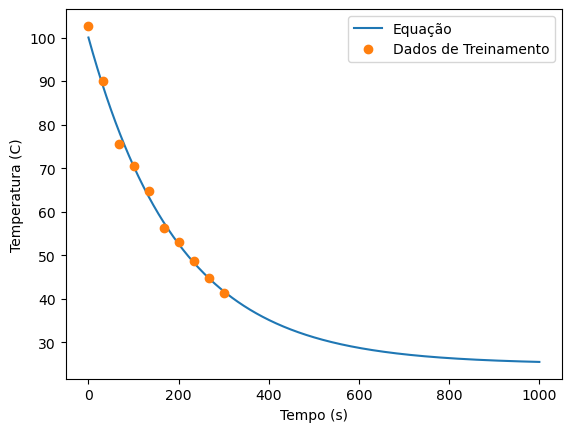

In [2]:
np.random.seed(10)

Tamb = 25
T0 = 100
k = 0.005
tempos = np.linspace(0, 1000, 1000)
eq = functools.partial(lei_esfri, Tamb=Tamb, T0=T0, k=k)
temps = eq(tempos)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t)+2*np.random.randn(10)

plt.plot(tempos, temps)
plt.plot(t, T, 'o')
plt.legend(['Equação', 'Dados de Treinamento'])

plt.ylabel('Temperatura (C)')
plt.xlabel('Tempo (s)')



Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2510.70
Epoch 4000/20000, loss: 2149.09
Epoch 6000/20000, loss: 726.83
Epoch 8000/20000, loss: 84.36
Epoch 10000/20000, loss: 1.49
Epoch 12000/20000, loss: 0.38
Epoch 14000/20000, loss: 0.34
Epoch 16000/20000, loss: 0.33
Epoch 18000/20000, loss: 0.30


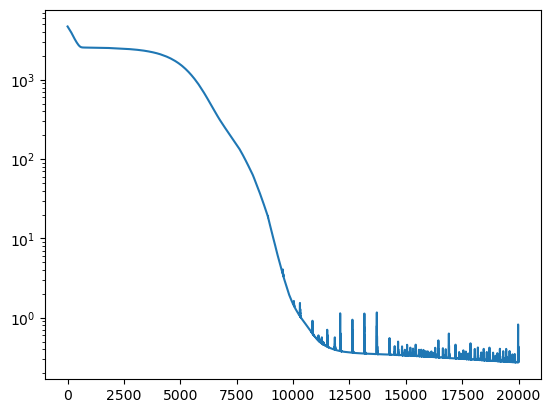

In [3]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [4]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))


Epoch 0/20000, loss: 11219.99
Epoch 2000/20000, loss: 3907.87
Epoch 4000/20000, loss: 2435.75
Epoch 6000/20000, loss: 1625.32
Epoch 8000/20000, loss: 1221.53
Epoch 10000/20000, loss: 1035.26
Epoch 12000/20000, loss: 937.95
Epoch 14000/20000, loss: 861.01
Epoch 16000/20000, loss: 789.80
Epoch 18000/20000, loss: 724.08


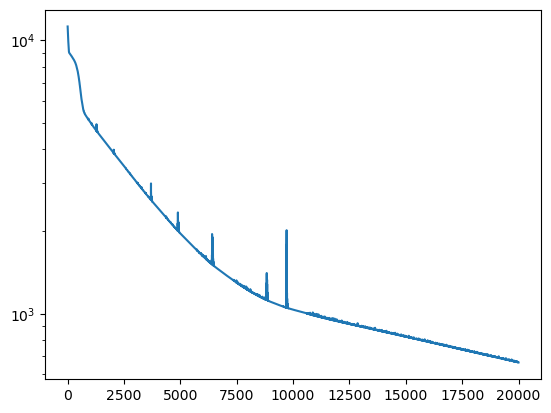

In [5]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')


Text(0.5, 0, 'Time (s)')

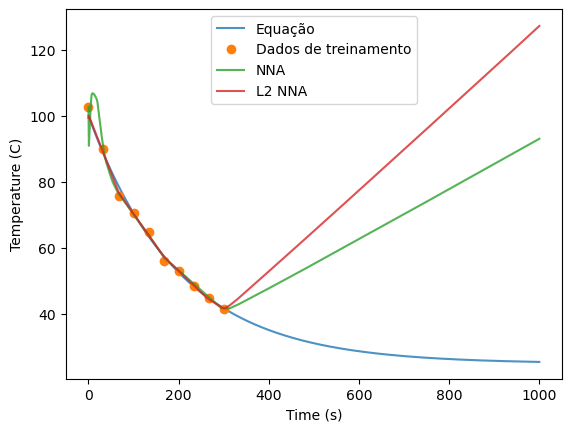

In [ ]:
predsreg = netreg.predict(tempos)

preds = net.predict(tempos)
plt.plot(tempos, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(tempos, preds, alpha=0.8)
plt.plot(tempos, predsreg, alpha=0.8)

plt.legend(labels=['Equação','Dados de treinamento', 'NNA', 'L2 NNA'])
plt.ylabel('Temperatura (C)')
plt.xlabel('Tempo (s)')


In [9]:
# PINNs
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = k*(Tamb-temps)-dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4775.84
Epoch 3000/30000, loss: 2436.37
Epoch 6000/30000, loss: 507.98
Epoch 9000/30000, loss: 1.00
Epoch 12000/30000, loss: 0.36
Epoch 15000/30000, loss: 0.35
Epoch 18000/30000, loss: 0.34
Epoch 21000/30000, loss: 0.33
Epoch 24000/30000, loss: 0.34
Epoch 27000/30000, loss: 0.33


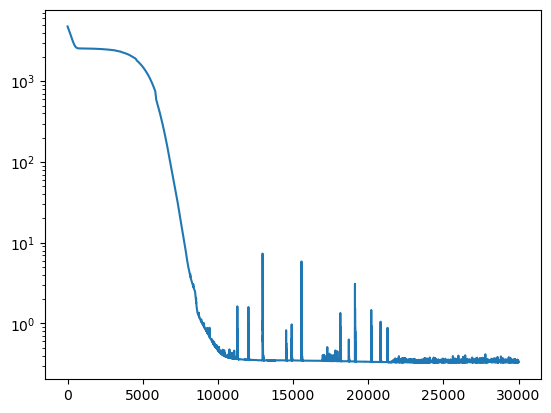

In [10]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

In [1]:
preds = net.predict(tempos)

plt.plot(tempos, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(tempos, preds, alpha=0.8)
plt.legend(labels=['Equação','Dados de treinamento', 'PINN'])
plt.ylabel('Temperatura (C)')
plt.xlabel('Tempo (s)')


NameError: name 'net' is not defined

In [12]:
# Descobrir o parâmetro k: taxa de esfriamento
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r *(Tamb - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/40000, loss: 4816.01
Epoch 4000/40000, loss: 2499.93
Epoch 8000/40000, loss: 2041.76
Epoch 12000/40000, loss: 478.75
Epoch 16000/40000, loss: 3.67
Epoch 20000/40000, loss: 1.72
Epoch 24000/40000, loss: 1.14
Epoch 28000/40000, loss: 0.59
Epoch 32000/40000, loss: 0.35
Epoch 36000/40000, loss: 0.22


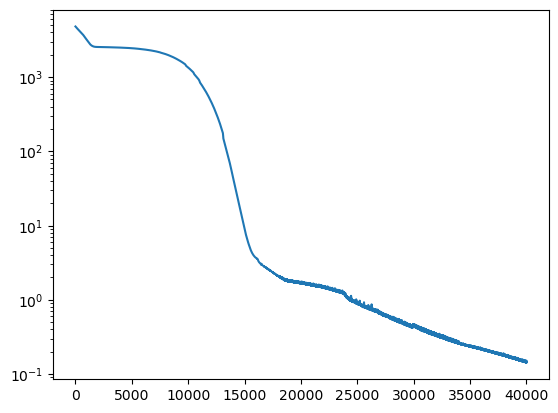

In [13]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Parameter containing:
tensor([0.0050], requires_grad=True)


Text(0.5, 0, 'Tempo (s)')

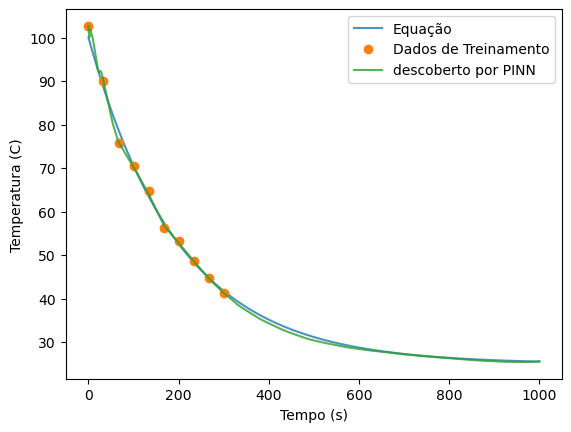

In [14]:
preds = netdisc.predict(tempos)
print(netdisc.r)

plt.plot(tempos, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(tempos, preds, alpha=0.8)
plt.legend(labels=['Equação','Dados de Treinamento', 'descoberto por PINN'])
plt.ylabel('Temperatura (C)')
plt.xlabel('Tempo (s)')